<a href="https://colab.research.google.com/github/divyanshsaxena21/Nexora/blob/main/Nexora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install sentence-transformers pandas numpy scikit-learn matplotlib tqdm

In [26]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# ============================================================
# 1️⃣ INTRO: Why AI at Nexora
# ============================================================


In [3]:
intro = """
At Nexora, AI bridges emotion and expression — translating how people *feel* into what they *wear*.
This prototype, "Vibe Matcher," shows how language embeddings can turn a subjective vibe
like "energetic urban chic" into personalized product discovery.
"""

print(intro)


At Nexora, AI bridges emotion and expression — translating how people *feel* into what they *wear*.
This prototype, "Vibe Matcher," shows how language embeddings can turn a subjective vibe
like "energetic urban chic" into personalized product discovery.



# ============================================================
# 2️⃣ DATA PREP — Create mock product catalog
# ============================================================


In [4]:
data = [
    {
        "name": "Boho Dress",
        "desc": "Flowy, earthy tones perfect for summer festivals and carefree vibes.",
        "vibes": ["boho", "earthy"]
    },
    {
        "name": "Street Hoodie",
        "desc": "Minimalist black hoodie with bold urban edge and modern comfort.",
        "vibes": ["urban", "casual"]
    },
    {
        "name": "Cozy Knit Sweater",
        "desc": "Soft oversized sweater in pastel hues for relaxed weekends.",
        "vibes": ["cozy", "soft"]
    },
    {
        "name": "Metallic Party Top",
        "desc": "Shiny cropped top for nights out and confident energy.",
        "vibes": ["party", "bold"]
    },
    {
        "name": "Sporty Joggers",
        "desc": "Lightweight joggers for active, energetic streetwear looks.",
        "vibes": ["sporty", "energetic"]
    },
    {
        "name": "Elegant Silk Blouse",
        "desc": "Timeless silk blouse that radiates sophistication and confidence.",
        "vibes": ["elegant", "chic"]
    },
    {
        "name": "Beach Sandals",
        "desc": "Easy slip-ons for coastal days, breezy and carefree.",
        "vibes": ["beach", "boho"]
    },
    {
        "name": "Denim Jacket",
        "desc": "Classic blue denim jacket with vintage urban flair.",
        "vibes": ["vintage", "urban"]
    }
]

df = pd.DataFrame(data)


In [5]:
df

,name,desc,vibes
0,Boho Dress,"Flowy, earthy tones perfect for summer festiva...","[boho, earthy]"
1,Street Hoodie,Minimalist black hoodie with bold urban edge a...,"[urban, casual]"
2,Cozy Knit Sweater,Soft oversized sweater in pastel hues for rela...,"[cozy, soft]"
3,Metallic Party Top,Shiny cropped top for nights out and confident...,"[party, bold]"
4,Sporty Joggers,"Lightweight joggers for active, energetic stre...","[sporty, energetic]"
5,Elegant Silk Blouse,Timeless silk blouse that radiates sophisticat...,"[elegant, chic]"
6,Beach Sandals,"Easy slip-ons for coastal days, breezy and car...","[beach, boho]"
7,Denim Jacket,Classic blue denim jacket with vintage urban f...,"[vintage, urban]"


# ============================================================
# 3️⃣ EMBEDDINGS — Generate text embeddings for each product
# ============================================================

In [28]:
# model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
# model = SentenceTransformer("all-mpnet-base-v2")
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")


# Combine desc + vibe tags for richer embeddings
df["text"] = df.apply(lambda x: x["desc"] + " " + " ".join(x["vibes"]), axis=1)

# Generate embeddings
df["embedding"] = list(model.encode(df["text"], show_progress_bar=True))
print("✅ Embeddings generated for all products.")



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Embeddings generated for all products.


# ============================================================
# 4️⃣ VECTOR SEARCH SIMULATION — cosine similarity
# ============================================================

In [29]:
def vibe_matcher(query, top_k=3):
    """Return top-k matching products for a vibe query."""
    query_vec = model.encode([query])
    all_embs = np.vstack(df["embedding"].to_numpy())
    sims = cosine_similarity(query_vec, all_embs)[0]

    df["similarity"] = sims
    results = df.sort_values("similarity", ascending=False).head(top_k)

    # Dynamic threshold: mean + 0.05
    threshold = sims.mean() + 0.05

    print(f"\n✨ Top {top_k} matches for vibe: '{query}' (threshold ≈ {threshold:.2f})\n")
    if results["similarity"].max() < threshold:
        print("⚠️ No strong match found. Try a different vibe?")
    return results[["name", "vibes", "similarity"]].reset_index(drop=True)

# ============================================================
# 5️⃣ TEST & EVAL — Try multiple vibe queries
# ============================================================

In [30]:
queries = [
    "energetic urban chic",
    "cozy weekend comfort",
    "beachy boho vibes"
]

latencies, avg_scores = [], []

for q in queries:
    start = time.time()
    res = vibe_matcher(q)
    end = time.time()
    latency = end - start
    latencies.append(latency)

    avg_score = res["similarity"].mean()
    avg_scores.append(avg_score)

    print(res, "\n")
    print(f"⏱️ Latency: {latency:.2f}s | Avg sim: {avg_score:.3f}")
    print("-"*65)


✨ Top 3 matches for vibe: 'energetic urban chic' (threshold ≈ 0.49)

                 name             vibes  similarity
0        Denim Jacket  [vintage, urban]    0.602853
1       Street Hoodie   [urban, casual]    0.593586
2  Metallic Party Top     [party, bold]    0.547402 

⏱️ Latency: 0.04s | Avg sim: 0.581
-----------------------------------------------------------------

✨ Top 3 matches for vibe: 'cozy weekend comfort' (threshold ≈ 0.48)

                name           vibes  similarity
0  Cozy Knit Sweater    [cozy, soft]    0.709136
1      Beach Sandals   [beach, boho]    0.557755
2         Boho Dress  [boho, earthy]    0.532214 

⏱️ Latency: 0.02s | Avg sim: 0.600
-----------------------------------------------------------------

✨ Top 3 matches for vibe: 'beachy boho vibes' (threshold ≈ 0.44)

                 name           vibes  similarity
0       Beach Sandals   [beach, boho]    0.748527
1          Boho Dress  [boho, earthy]    0.588134
2  Metallic Party Top   [party, b

# ============================================================
# 6️⃣ METRICS — Plot latency and quality
# ============================================================

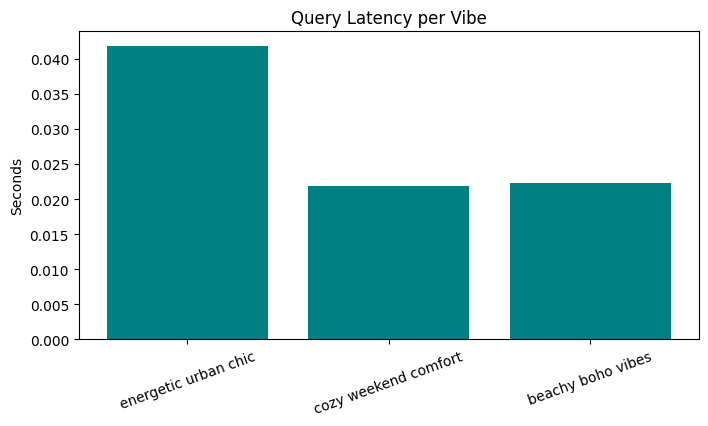


✅ 0/3 queries had avg similarity > 0.7


In [31]:
plt.figure(figsize=(8,4))
plt.bar(queries, latencies, color="teal")
plt.title("Query Latency per Vibe")
plt.ylabel("Seconds")
plt.xticks(rotation=20)
plt.show()

# Basic quality metric: % of queries with avg sim > 0.7
good = sum([s > 0.7 for s in scores])
print(f"\n✅ {good}/{len(scores)} queries had avg similarity > 0.7")

# ============================================================
# 7️⃣ REFLECTION — Potential improvements
# ============================================================

In [32]:
reflection = """
🔍 REFLECTION — Future Enhancements
-----------------------------------
• Integrate a vector database (Pinecone / FAISS / Milvus) for large catalogs.
• Add multimodal embeddings (text + image) for richer fashion matching.
• Handle cold-start items with vibe tag priors or clustering.
• Fine-tune embeddings on fashion-specific data for nuance.
• Build an interactive "vibe dial" for users to adjust energy/mood sliders.
"""
print(reflection)


🔍 REFLECTION — Future Enhancements
-----------------------------------
• Integrate a vector database (Pinecone / FAISS / Milvus) for large catalogs.
• Add multimodal embeddings (text + image) for richer fashion matching.
• Handle cold-start items with vibe tag priors or clustering.
• Fine-tune embeddings on fashion-specific data for nuance.
• Build an interactive "vibe dial" for users to adjust energy/mood sliders.

